In [ ]:
#######################################################################
#
# lvm-dap-get-out-mod: LVM-DAP notebook to regenerate the model spectra
# based on the LVM-DAP fitting
#
# 
# Notebook version of the lvm-dap-get-out-mod script. 
#
#

In [7]:
###########################################################################
#
# Defining the environment settings and loading the required models
#
###########################################################################
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Core Python libraries
import numpy as np
import yaml
from astropy.table import Table
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from astropy.io import fits

# pyFIT3D and LVM DAP imports (assuming they are installed in your environment)
from lvmdap.pyFIT3D.common.io import clean_preview_results_files, print_time
from lvmdap.pyFIT3D.common.io import trim_waves
from lvmdap.dap_tools import (
    load_LVM_rss, load_LVMSIM_rss, load_in_rss,
    read_PT, read_MaStar_PT, read_LVMSIM_PT,
    read_tab_EL, find_redshift_spec,
    plot_spec_art, plot_spec, fit_legendre_polynomial,
    read_rsp, read_coeffs_RSP, read_elines_RSP, Table_mean_rows,
    replace_nan_inf_with_adjacent_avg, find_continuum, find_closest_indices,
    find_closest_indices_different, read_RSS_PT
)
from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
from lvmdap.dap_tools import sort_table_by_id
#from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
#from lvmdap.modelling.auto_rsp_tools import auto_rsp_elines_rnd
from lvmdap._cmdline.dap import auto_rsp_elines_rnd
from lvmdap.dap_tools import nanaverage, read_DAP_file

from lvmdap.pyFIT3D.common.constants import __c__, __Ha_central_wl__, _MODELS_ELINE_PAR
from lvmdap.pyFIT3D.common.auto_ssp_tools import load_rss, dump_rss_output
from astropy.table import join as tab_join
from astropy.table import vstack as vstack_table
from lvmdap.pyFIT3D.common.gas_tools import kin_rss_elines_main
#from lvmdap.elines.kin_elines import kin_rss_elines_main, _MODELS_ELINE_PAR
#from lvmdap.dap_tools import trim_waves

In [177]:
from lvmdap._cmdline.dap import auto_rsp_elines_rnd
from lvmdap.pyFIT3D.common.stats import calc_chi_sq, smooth_ratio, shift_convolve, hyperbolic_fit_par
from lvmdap.pyFIT3D.common.constants import __c__, __shift_convolve_lnwl_frac__, __sigma_to_FWHM__
from lvmdap.pyFIT3D.modelling.dust import spec_apply_dust
from lvmdap.pyFIT3D.common.io import array_to_fits, trim_waves, sel_waves, print_verbose, write_img_header


In [43]:
def eline(w,W,F,D,V,dap_fwhm=2.354):
  c = 299792.00
  w0 = W*(1+(V/c))
  sigma=D/dap_fwhm
  e1=np.exp(-0.5*((w-w0)/sigma)**2)
  return F*e1/(sigma*((2*3.1416)**0.5))     


def _no_traceback(type, value, traceback):
  print(value)


In [9]:
############################################################################
# We define the input parameters
############################################################################

lvmCFrame = "data_v1.1.1/lvmSFrame-00006109.fits"
label = "dap-nb-00006109_few_mod" #config["label"]
dap_file = "output_dap_v1.1.0_tests/dap-nb-00006109_few.dap.fits.gz"





In [19]:
hdu_DAP = fits.open(dap_file)
tab_config = Table(hdu_DAP['INFO'].data)
hdu_DAP.close()

In [47]:
config = {}
for tab_now in tab_config:
    key = tab_now['param']
    val = tab_now['value']
    config[key] = val    
config
dap_fwhm = 1.0
f_scale=1e16

In [28]:
#
# If you use a range of spectra you have to add it manually
#

config['ny_range'] = (0,200)


In [24]:
#
#
#
print("##############################################")
print("# Reading input files...")
hdu_org=fits.open(lvmCFrame)
tab_DAP=read_DAP_file(dap_file,verbose=False)
tab_DAP.sort('fiberid')
print(f"# N.Spec. input: {len(tab_DAP)}")                                
print("# Done...")
print("##############################################")





##############################################
# Reading input files...
# N.Spec. input: 174
# Done...
##############################################


In [25]:
out_file_fit = os.path.join(config['output_path'], f"{label}.output.fits.gz")

In [29]:

try:
  smooth_size = config['smooth_size']
except:
  smooth_size = 21

try:
  n_leg = config['n_leg']
except:
  n_leg = 11

In [39]:
tab_PT_org = read_PT(lvmCFrame,'none',ny_range=None)
print(len(tab_PT_org))


1944


In [ ]:
if (config['ny_range'] is not None) and (config['ny_range'][0] is not None):    
    tab_PT_org_range = tab_PT_org[config['ny_range'][0]:config['ny_range'][1]]
    print(len(tab_PT_org_range))
    hdu_org['FLUX'].data=hdu_org['FLUX'].data[config['ny_range'][0]:config['ny_range'][1],:]
    hdu_org['FLUX'].data=hdu_org['FLUX'].data[tab_PT_org_range['mask']]
else:
    hdu_org['FLUX'].data=hdu_org['FLUX'].data[tab_PT_org['mask']]
hdu_org['FLUX'].data = replace_nan_inf_with_adjacent_avg( hdu_org['FLUX'].data)

200


/home/sanchez/.local/lib/python3.8/site-packages/lvmdap/dap_tools.py:179: RuntimeWarning: invalid value encountered in true_divide
  adjacent_avg = convolved_sum / convolved_mask


In [41]:
wave = hdu_org['WAVE'].data
crpix1 = 1
crval1 = wave[0]
cdelt1 = wave[1]-wave[0]
(ny,nx)=hdu_org['FLUX'].data.shape
model_spectra = np.zeros((9,ny,nx))
hdr_out = fits.Header()
model_spectra[0,:,:]=hdu_org['FLUX'].data
hdr_out['CRPIX1'] = crpix1
hdr_out['CRVAL1'] = crval1
hdr_out['CDELT1'] = cdelt1
# Add the NAME fields
hdr_out['NAME0'] = 'org_spec'
hdr_out['NAME1'] = 'model_spec'
hdr_out['NAME2'] = 'mod_joint_spec'
hdr_out['NAME3'] = 'gas_spec'
hdr_out['NAME4'] = 'res_joint_spec'
hdr_out['NAME5'] = 'no_gas_spec'
hdr_out['NAME6'] = 'np_mod_spec'
hdr_out['NAME7'] = 'pe_mod_spec'
hdr_out['NAME8'] = 'pk_mod_spec'


In [48]:
pe_e=[]
w_e = []
for td_col in tab_DAP.columns:
    if ((td_col.find("_pe_") == -1) & (td_col.find("_pek_") == -1) & (td_col.find("e_flux_") > -1)):
        l_name = td_col.replace('e_flux_', '')
        w_name = float(l_name.split("_")[-1])
        pe_e.append(l_name)
        w_e.append(w_name)
print(f'# Number of emission lines in the model: {len(pe_e)}')
#
# Create emission lines!
#
print("##############################################")
print('# Creating NP the emission line models\n')
spec2D_elines = 0.0 * hdu_org['FLUX'].data
for i, spec2D_now in enumerate(spec2D_elines):
    for j, (pe_now, w_now) in enumerate(zip(pe_e, w_e)):
        F = np.abs(tab_DAP[f'flux_{pe_now}'][i])
        D = tab_DAP[f'disp_{pe_now}'][i]
        V = tab_DAP[f'vel_{pe_now}'][i]
        spec_eline = eline(wave, w_now, F, D, V, dap_fwhm=dap_fwhm)
        spec2D_now += spec_eline

print("# Done...")
print("##############################################")
model_spectra[6, :, :] = np.copy(spec2D_elines / f_scale)

pe_e = []
w_e = []
for td_col in tab_DAP.columns:
    if ((td_col.find("_pe_") > -1) & (td_col.find("_pek_") == -1) & (td_col.find("e_flux_") > -1)):
        l_name = td_col.replace('e_flux_', '')
        w_name = float(l_name.split("_")[-1])
        pe_e.append(l_name)
        w_e.append(w_name)
print(f'# Number of emission lines in the model: {len(pe_e)}')
#
# Create emission lines!
#
print("##############################################")
print('# Creating the emission line models\n')
spec2D_elines = 0.0 * hdu_org['FLUX'].data
for i, spec2D_now in enumerate(spec2D_elines):
    for j, (pe_now, w_now) in enumerate(zip(pe_e, w_e)):
        F = np.abs(tab_DAP[f'flux_{pe_now}'][i])
        D = tab_DAP[f'disp_{pe_now}'][i]
        V = tab_DAP[f'vel_{pe_now}'][i]
        spec_eline = eline(wave, w_now, F, D, V, dap_fwhm=dap_fwhm)
        spec2D_now += spec_eline

print("# Done...")
print("##############################################")
model_spectra[7, :, :] = np.copy(spec2D_elines / f_scale)


# Number of emission lines in the model: 215
##############################################
# Creating NP the emission line models

# Done...
##############################################
# Number of emission lines in the model: 15
##############################################
# Creating the emission line models

# Done...
##############################################


In [133]:
seed = print_time(print_seed=False, get_time_only=True)

##############################################################
# We extract the ifnormation from the DAP table
# corresponding to the stellar population model
##############################################################
a_redshift=np.array(tab_DAP['redshift_st'])
a_sigma=np.array(tab_DAP['disp_st'])
a_AV=np.array(tab_DAP['Av_st'])
#a_flux_st=np.array(tab_DAP['flux_st'])
a_flux_st=np.array(tab_DAP['med_flux_st'])
n_coeffs=0
for cols in tab_DAP.columns:
      if (cols.find('min_W_rsp_')>-1):
        n_coeffs=n_coeffs+1
print(f'# N.RSP: {n_coeffs}')
a_coeffs_input = np.zeros((ny,n_coeffs))
for i in np.arange(n_coeffs):
  w_id = f'W_rsp_{i}'
  a_coeffs_input[:,i]=np.array(tab_DAP[w_id])
  


# N.RSP: 108


In [117]:
tab_DAP.colnames

['id',
 'ra',
 'dec',
 'mask',
 'fiberid',
 'exposure',
 'MIN_CHISQ',
 'Teff',
 'e_Teff',
 'Log_g',
 'e_Log_g',
 'Fe',
 'e_Fe',
 'alpha',
 'e_alpha',
 'Av_st',
 'e_Av_st',
 'z_st',
 'e_z_st',
 'disp_st',
 'e_disp_st',
 'flux_st',
 'redshift_st',
 'med_flux_st',
 'e_med_flux_st',
 'Teff_MW',
 'e_Teff_MW',
 'Log_g_MW',
 'e_Log_g_MW',
 'Fe_MW',
 'e_Fe_MW',
 'alpha_MW',
 'e_alpha_MW',
 'vel_st',
 'log_ML',
 'log_Mass',
 'flux_HI_3686.83',
 'flux_HI_3691.56',
 'flux_HI_3697.15',
 'flux_HI_3703.85',
 'flux_HI_3711.97',
 'flux_[OII]_3726.03',
 'flux_[OII]_3728.82',
 'flux_HI_3734.37',
 'flux_HI_3750.15',
 'flux_[FeVII]_3758.9',
 'flux_HI_3770.63',
 'flux_HI_3797.9',
 'flux_HeI_3819.61',
 'flux_HI_3835.38',
 'flux_[NeIII]_3868.75',
 'flux_HeI_3888.65',
 'flux_HI_3889.05',
 'flux_CaII_3933.66',
 'flux_HeI_3964.73',
 'flux_[NeIII]_3967.46',
 'flux_CaII_3968.47',
 'flux_Hepsilon_3970.07',
 'flux_HeI_4026.19',
 'flux_[SII]_4068.6',
 'flux_[SII]_4076.35',
 'flux_Hdelta_4101.77',
 'flux_HeI_4120.81'

In [68]:
tab_config

param,value
str24,str64
output_path,/disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests
lvmdap_dir,/home/sanchez/sda2/code/python/lvmdap
rsp-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
sigma-inst,1
rsp-nl-file,/disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-12.fits.gz
input-fmt,rss
redshift,"[0.0, 5e-05, -0.0003, 0.0003]"
sigma,"[1, 5, 0.1, 30]"
AV,"[0, 0.3, 0.0, 2.5]"


In [ ]:
###################################################################################
# We read the RSP file
###################################################################################
hdu_rsp = fits.open(config['rsp-file'])
rsp_data = hdu_rsp['SPECTRA'].data
rsp_wave = hdu_rsp['SPECTRA'].header['CRVAL1']+ hdu_rsp['SPECTRA'].header['CDELT1']* (np.arange(0, hdu_rsp['SPECTRA'].header['NAXIS1']))
hdu_rsp.info()

Filename: /disk-a/sanchez/LVM/LVM/ver_231113/mstar-stlib-cl-108.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRA       1 PrimaryHDU      13   (6351, 108)   float32   
  1  PARAMETERS    1 BinTableHDU     29   108R x 10C   [D, E, E, E, E, E, E, E, E, E]   
  2  ERROR         1 ImageHDU        14   (6351, 108)   float32   
  3  ORG_PARAM     1 BinTableHDU     31   1235R x 11C   [K, E, E, E, E, E, E, E, E, E, J]   
  4  PDF_TEFF_LOGG    1 ImageHDU        17   (100, 100, 108)   float64   
  5  PDF_TEFF_MET    1 ImageHDU        17   (100, 100, 108)   float64   
  6  PDF_TEFF_ALPHAM    1 ImageHDU        17   (100, 100, 108)   float64   
  7  PDF_MET_ALPHAM    1 ImageHDU        17   (100, 100, 108)   float64   
  8  PDF_MET_LOGG    1 ImageHDU        17   (100, 100, 108)   float64   
  9  PDF_LOGG_MET    1 ImageHDU        17   (100, 100, 108)   float64   


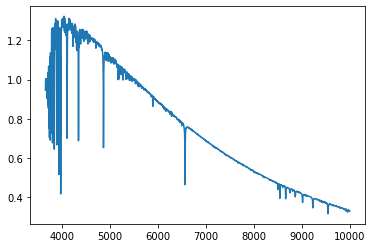

In [74]:
plt.plot(rsp_wave, rsp_data[0,:])

In [104]:
print(1.0*config['sigma-inst'].astype(float))
#config
print(wave)
print(rsp_wave)

1.0
[3600.    3600.5   3601.    ... 9799.    9799.5   9799.999]
[ 3650.  3651.  3652. ...  9998.  9999. 10000.]


In [109]:
ln_wave = np.log(wave)
print(ln_wave[0],ln_wave[1])

8.188689 8.188828


In [153]:
###################################################################################
# We create the model spectra
###################################################################################
for i,model_st in enumerate(model_spectra[1,:,:]):
   # print(f'### {i}/{ny}')
   # print(f'### (AV,redshift,sigma) : {a_AV[i]},{a_redshift[i]},{a_sigma[i]}')
    coeffs_input = a_coeffs_input[i,:]
    org_spec = hdu_org['FLUX'].data[i,:]
    res_spec = 0.1*np.abs(org_spec)
    wl__w, f__w, ef__w = wave, org_spec, res_spec
    model_rsp = np.nansum(rsp_data.T*coeffs_input,axis=1)
    #print(model_rsp.shape)
    model_rsp = shift_convolve(wave, rsp_wave, model_rsp, a_redshift[i], a_sigma[i], config["sigma-inst"].astype(float))
    model_spectra[1,i,:] = spec_apply_dust(wave, model_rsp*a_flux_st[i]/f_scale, a_AV[i], R_V=3.1, extlaw='CCM')
    print('.',end='')



..............................................................................................................................................................................

In [182]:
res_spectra = model_spectra[0,:,:] - model_spectra[1,:,:] - model_spectra[6,:,:]
l_smooth_spectra = res_spectra*0.0
#config['n_leg'] = 3
print(smooth_size,n_leg)
for idx,res in enumerate(res_spectra): 
    smooth = median_filter(res, size=config.get("smooth_size", 21))
    l_smooth = fit_legendre_polynomial(wave, smooth, config.get("n_leg", 51))
    l_smooth_spectra[idx] = l_smooth
model_spectra[2,:,:] = model_spectra[1,:,:] + model_spectra[6,:,:] + l_smooth_spectra
model_spectra[3,:,:] = model_spectra[0,:,:] - (model_spectra[1,:,:] + l_smooth_spectra)
model_spectra[4,:,:] = model_spectra[0,:,:] - model_spectra[2,:,:]
model_spectra[5,:,:] = model_spectra[0,:,:] - model_spectra[6,:,:]
model_spectra[8,:,:] = model_spectra[1,:,:] + model_spectra[7,:,:] + l_smooth_spectra



21 11


In [183]:
print(model_spectra.shape)

(9, 174, 12401)


In [184]:
##################################################################################
# Writting the result
##################################################################################
#dump_rss_output(out_file_fit=out_file_fit, wavelength=wl__w, model_spectra=model_spectra)

fits_name = out_file_fit if out_file_fit.endswith(".gz") else out_file_fit+".gz"
       # hdr = fits.Header()
h = {}
h['CRPIX1'] = 1
h['CRVAL1'] = wave[0]
h['CDELT1'] = wave[1] - wave[0]
h['NAME0'] = 'org_spec'
h['NAME1'] = 'model_spec'
h['NAME2'] = 'mod_joint_spec'
h['NAME3'] = 'gas_spec'
h['NAME4'] = 'res_joint_spec'
h['NAME5'] = 'no_gas_spec'
h['NAME6'] = 'gas_model_NP'
h['NAME7'] = 'gas_model_PEK'
h['NAME8'] = 'mod_joint_spec_PEK'
h["FILENAME"] = fits_name
array_to_fits(fits_name, model_spectra, overwrite=True)
write_img_header(fits_name, list(h.keys()), list(h.values()))



(-5e-15, 3e-14)

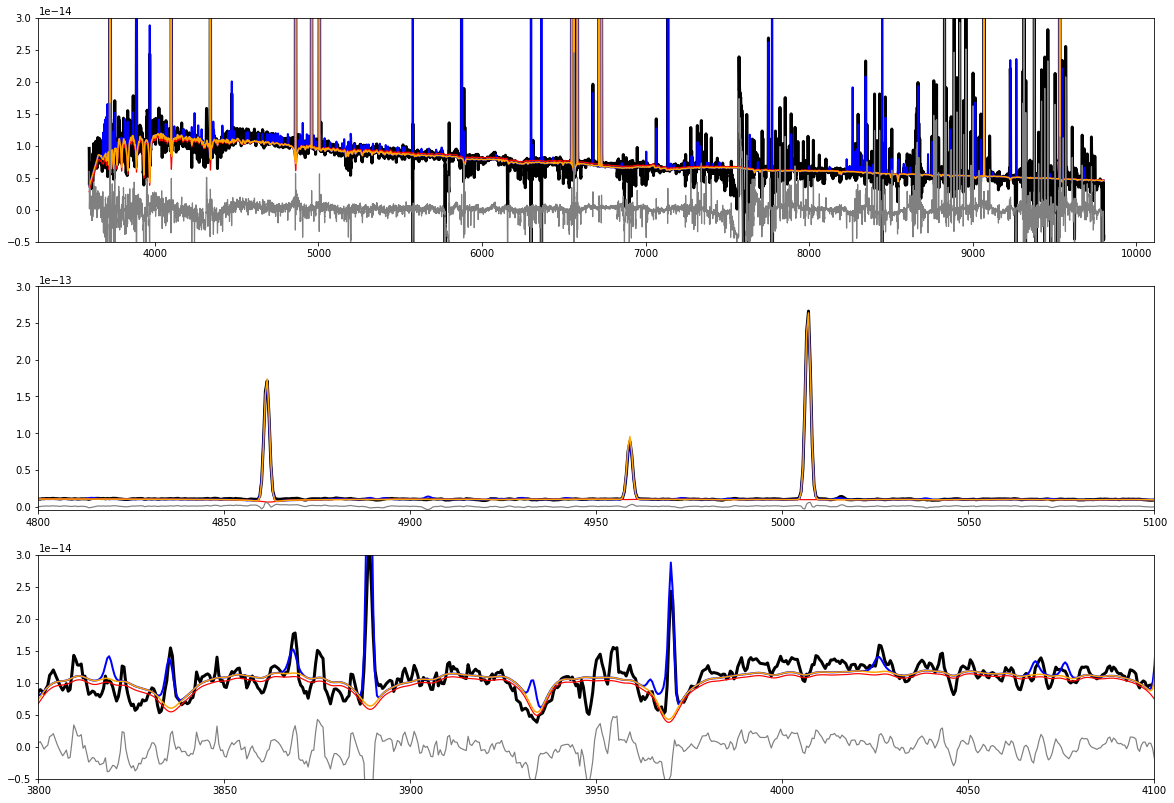

In [207]:
##################################################################################
# We plot the average spectra and the average model spectra
##################################################################################

%matplotlib inline
fig, ax = plt.subplots(3, 1, figsize=(20, 14))
#plt.imshow(model_spectra[7, :, :], aspect='auto', origin='lower')

for ax_now in ax.flatten():
    ax_now.plot(wave, np.nanmean(model_spectra[0, :, :],axis=0),color='black',linewidth=3)
    ax_now.plot(wave, np.nanmean(model_spectra[2, :, :],axis=0),color='blue',linewidth=2,alpha=1.0)
#    ax_now.plot(wave, np.nanmean(model_spectra[6, :, :],axis=0),color='blue',linewidth=1.5)
#    ax_now.plot(wave, np.nanmean(model_spectra[7, :, :],axis=0),color='darkblue',linewidth=1.5)
    ax_now.plot(wave, np.nanmean(model_spectra[1, :, :],axis=0),color='red',linewidth=1.2)
    ax_now.plot(wave, np.nanmean(model_spectra[8, :, :],axis=0),color='orange',linewidth=1.5,alpha=1.0)
    ax_now.plot(wave, np.nanmean(model_spectra[4, :, :],axis=0),color='grey',linewidth=1.2)
#ax[0].set_xlim(3800, 4100)
ax[0].set_ylim(-50/f_scale, 300/f_scale)

ax[1].set_xlim(4800, 5100)
ax[1].set_ylim(-50/f_scale, 3000/f_scale)

ax[2].set_xlim(3800, 4100)
ax[2].set_ylim(-50/f_scale, 300/f_scale)
#plt.show()